### 173 samples, Final_R is missing for the following sample
137)	MC	air	204	8	180	60	180	500	30	114	0.3	NA	150	0.3	100	0.490196078	486.395	57.78712883	26.00664167	0.467	9.68631173	3	0.422680412	0.541775715	0.521526486	44.36424367

In [35]:
# Import Python libaries
%matplotlib inline
from scipy.optimize import curve_fit
import time as time
# General data management
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc, rcParams

import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn import ensemble
from xgboost import plot_tree
from sklearn.tree import DecisionTreeRegressor
# import pydo
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)
# Machine learning & model visualization tools
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error, mean_gamma_deviance, mean_absolute_error
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy import cov
from scipy.stats import pearsonr
from scipy import ndimage, misc

from scipy import stats 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
# from sklearn.externals import joblib
# Miscellaneous
import os
import io
import pydot
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as BK
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import statsmodels.api as sm
import statsmodels.formula.api as smf
#from sklearn.inspection import partial_dependence, plot_partial_dependence

from progressbar import ProgressBar
pbar = ProgressBar()

global_rand_state_split = 4
global_rand_state_xgb = 4

In [36]:
# proxy properties
# read the input data
df = pd.read_csv('FJH_ML_Final_simulation_90rem.csv', header=1)
df_dummy = pd.get_dummies(df)

df['Norm_charge_tot'] = df['Charge_Tot']/(df['Mass'])*1000
df['Norm_I_Max'] = df['I_Max']/df['Mass']*1000
df['charge_density'] = df['Voltage']*df['Cap']/df['Mass']
df['Final_Current_Percent'] = df['I_Final']/df['I_Max']

Norm_I_Max = np.array (df['Norm_I_Max']).reshape(-1, 1)
Final_Current_Percent  = np.array (df['Final_Current_Percent']).reshape(-1, 1)
Norm_charge_tot  = np.array (df['Norm_charge_tot']).reshape(-1, 1)
# final prediction, yield of Graphene
df['Graphene_Yield'] = 100*df['Graphene_Yield']
Graphene_Yield = np.array (df['Graphene_Yield']).reshape(-1, 1)

Init_R = np.array (df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (df['Volt_Drop']).reshape (-1, 1)
Mass = np.array (df['Mass']).reshape(-1, 1)

# only process parameters that are in BO prediction
Pretreat_voltage = np.array (df['Pretreat_voltage']).reshape(-1, 1)
pulsetime = np.array (df['PulseTime']).reshape(-1, 1)
charge_denisty = np.array (df['charge_density']).reshape(-1, 1)

In [37]:
# type of material
Material_CB = np.array (df_dummy['Material_CB']).reshape(-1, 1)
Material_MC = np.array (df_dummy['Material_MC']).reshape(-1, 1) 
Material_PA = np.array (df_dummy['Material_PA']).reshape(-1, 1)
Material_TCB = np.array (df_dummy['Material_TCB']).reshape(-1, 1)
material_type = np.concatenate ((Material_CB, Material_MC, Material_PA, Material_TCB), axis=1)

material_matrix = np.concatenate((np.array (df_dummy['Material_CB']).reshape([-1, 1]), 
                                  np.array (df_dummy['Material_MC']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_PA']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_TCB']).reshape([-1, 1])), axis=1)
material_matrix = np.array (material_matrix)

In [38]:
# physical properties of precursor received from Kevin
CB_ps_res_sa_sp2 = [45, 2.8, 1750, 41.2]
MC_ps_res_sa_sp2 = [150, 0.4, 18, 45.9]
PA_ps_res_sa_sp2 = [125, 7.2, 62, 42.4]
TCB_ps_res_sa_sp2 = [106, 6.3, 74, 30.6]
CB_MC_PA_TCB_ps_res_sa_sp2 = np.concatenate ([CB_ps_res_sa_sp2,
                 MC_ps_res_sa_sp2,
                 PA_ps_res_sa_sp2,
                 TCB_ps_res_sa_sp2], axis=0).reshape(4,4)
X_CB_MC_PA_TCB_ps_res_sa_sp2 = np.matmul(material_matrix, CB_MC_PA_TCB_ps_res_sa_sp2)

In [39]:
# type of Atmosphere
Atmosphere_air = np.array (df_dummy['Atmosphere_air']).reshape(-1, 1)
Atmosphere_arg = np.array (df_dummy['Atmosphere_arg']).reshape(-1, 1)
#Atmosphere_vac = np.array (df_dummy['Atmosphere_vac']).reshape(-1, 1)
atmosphere_type = np.concatenate ((Atmosphere_air, Atmosphere_arg), axis=1)

In [53]:
r_squareds_global = []
list_glob_rand_state = []
start = time.time()
pbar = ProgressBar()
# best split 2571, 2576
counter = 0
rgboost_rands = np.array (([94, 498, 482], [881, 344, 243], 
                          [66, 855, 905], [500, 800, 340], [840, 400, 500]))

for glob_split in pbar(range(2571, 2576)):
    #### Materials coef. for 3 time-current properties
    #print ('#### material coef. for 3 current properties')
    ## material coef. Final_Current_Percent
    input_features = np.concatenate((material_matrix, charge_denisty, Init_R, 
                                     Res_Drop, Volt_Drop, Graphene_Yield), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Final_Current_Percent, test_size=0.2, random_state=glob_split)
    
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0: 4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_IfImax: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_IfImax: ', pearr[0])
    
    ## material coef. I_max normalized
    input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                     X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)],
                                     Res_Drop, Volt_Drop), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Norm_I_Max, test_size=0.2, random_state=glob_split)
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_Imax: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_Imax: ', pearr[0])
    
    ## material coef.  Norm_charge_tot
    input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                     Res_Drop, Volt_Drop), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Norm_charge_tot, test_size=0.2, random_state=glob_split)
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0: 4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_chargetot: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_chargetot: ', pearr[0])
    material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
    material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
    material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot
    
    #### proxy XGBoost Final_Current_percent
    new_features = np.concatenate ((charge_denisty, pulsetime,
                                    material_type_I_Finalperc_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, train_mat, test_mat, idxtrain, idx_test = \
                          train_test_split(new_features, Final_Current_Percent, df['Material'],
                                         indices, test_size = 0.20, random_state = glob_split)
    xgbr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=20, gamma=0.001, 
                       learning_rate=0.0994, subsample=0.77, min_child_weight=9, n_jobs=1,
                       random_state=rgboost_rands[counter, 0])
    
    xgbr_final_I_percent.fit(train_new_features, train_labels)
    Final_Current_Percent_predicted = xgbr_final_I_percent.predict(new_features)  
    y_pred = xgbr_final_I_percent.predict(test_new_features)
    r_squared_Final_Current_test = r2_score(test_labels, y_pred)
    #print('r2 score = ', r_squared_Final_Current_test)
    pearsonr_Final_Current_test = pearsonr(test_labels.ravel(), y_pred.ravel())
    #print('Pearson r for test samples= ', pearsonr_Final_Current_test[0])

    #### proxy XGBoost Norm_I_Max
    new_features = np.concatenate ((charge_denisty,
                                    pulsetime, material_type_Norm_I_Max_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                          train_test_split(new_features, Norm_I_Max, 
                                           indices, test_size = 0.2, random_state = glob_split)  
    xgbr_norm_I_max = XGBRegressor(max_depth=5, n_estimators=35, gamma=0.001, 
                       learning_rate=0.09, subsample=0.775, min_child_weight=12, n_jobs=1,
                      random_state=rgboost_rands[counter, 1])
    
    xgbr_norm_I_max.fit(train_new_features, train_labels);
    Norm_I_Max_predicted = xgbr_norm_I_max.predict(new_features)
    Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
    r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
    #print('r2 score for test = ', r_squared_Norm_I_Max_test)
    pr_Norm_I_Max_test = pearsonr(test_labels.ravel(), Norm_I_Max_test.ravel())
    #print('pearson r for test= ', pr_Norm_I_Max_test[0])
    
    #### proxy XGBoost Norm_Norm_charge_tot
    #print ('#### proxy XGBoost Norm_Norm_charge_tot')
    new_features = np.concatenate ((charge_denisty,pulsetime,
                                    material_type_Norm_charge_Tot_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                          train_test_split(new_features, Norm_charge_tot, 
                                           indices, test_size = 0.20, random_state = glob_split)
    xgbr_norm_charge_total = XGBRegressor(max_depth=4, n_estimators=30, gamma=0.001, 
                   learning_rate=0.0994, subsample=0.75, min_child_weight=3, n_jobs=1,
                  random_state=rgboost_rands[counter, 2])
 
    xgbr_norm_charge_total.fit(train_new_features, train_labels)
    Norm_charge_tot_predicted = xgbr_norm_charge_total.predict(new_features)
    Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
    r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
    #print('r2 score for test= ', r_squared_Norm_charge_tot_test)
    pr_Norm_charge_tot_test = pearsonr(test_labels.ravel(), Norm_charge_tot_test.ravel())
    #print('pearson r for test= ', pr_Norm_charge_tot_test[0])
    
    #### FINAL prediction of Graphene Yield
    CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
    resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
    heat_power = np.array (df['Voltage']*df['Voltage']/(resistance_matrix**1)*df['PulseTime']*(1e-6)).reshape(-1, 1)
    CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                                 CB_MC_PA_coef_Norm_I_Max +
                                 CB_MC_PA_coef_Norm_charge_tot)/3

    material_type_GY_coef = material_type * CB_MC_PA_TCB_coef_average
    new_features = np.concatenate ((charge_denisty, 
                                    X_CB_MC_PA_TCB_ps_res_sa_sp2,
                                    #np.array(df['Volt_Drop']/df['I_Mean']).reshape(-1, 1),
                                    #material_type_GY_coef,
                                    pulsetime,
                                    Pretreat_voltage,
                                    (np.array (df['temp2']).reshape(-1, 1))/1000,
                                    atmosphere_type,
                                    Final_Current_Percent_predicted.reshape(-1, 1),
                                    Norm_I_Max_predicted.reshape(-1, 1),
                                    Norm_charge_tot_predicted.reshape(-1, 1), 
                                    heat_power.reshape(-1, 1)), axis=1)
    test_size = 0.2
    indices = np.arange(len(new_features))
    labels = Graphene_Yield
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                          train_test_split(new_features, labels, 
                                           indices, test_size = test_size, random_state=glob_split)
    r_squareds = list()
    r_squareds_randomized_testtrain = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    r2_max = 0
    test_split_seed1 = glob_split
    test_split_seed2 = glob_split + 1
    test_split_count = test_split_seed2 - test_split_seed1
    rep=10
    r_squareds = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    # rand = 499 with max of:  0.79
    for random_state in range (499, 500):
        # Instantiate model with 1000 decision trees
        xgbr_graphyield = XGBRegressor(max_depth=4, n_estimators=42, gamma=0.001, 
                   learning_rate=0.099383, subsample=0.7746, min_child_weight=3, n_jobs=1,
                   random_state=random_state)
        # Train the model on training data
        xgbr_graphyield.fit(train_new_features, train_labels);
        predictions = xgbr_graphyield.predict(test_new_features)
        r_squared = r2_score(test_labels, predictions)
        r_squareds.append (r_squared)
    #m = tf.keras.metrics.RootMeanSquaredError()
    pred_test = predictions
    #m.update_state(pred_test, test_labels)
    #print ('RMSE for test, ', m.result().numpy())
    r_squareds_randomized_testtrain_vec = np.array ((r_squareds_randomized_testtrain))
    #print ('all r2: ', r_squareds_randomized_testtrain_vec)
    r_squareds_global.append(r_squareds)
    list_glob_rand_state.append(glob_split)
    counter += 1

print (np.mean(r_squareds_global))
end = time.time()
print ('time is : ', end-start)

0.8131662350597972
time is :  0.23453998565673828


mean of R2 0.8131662350597972
random of  0 with max of:  0.8713456140025564


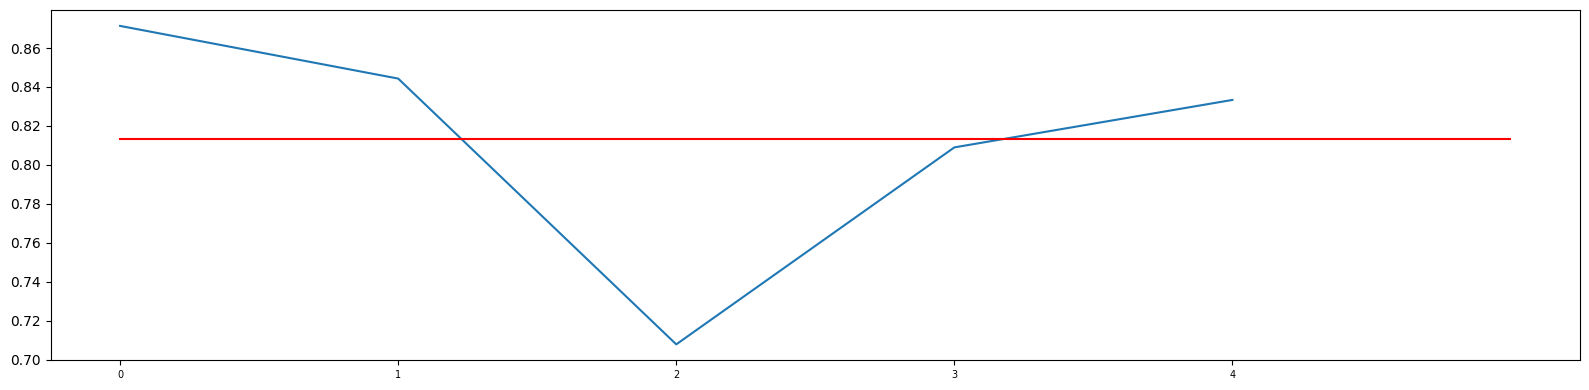

In [41]:
# if you want to check what global random for training testing split is good:
print ('mean of R2', np.mean(r_squareds_global))
plt.subplots(figsize=(16, 4))
#r_squareds_global_mean = np.mean (np.array (r_squareds_global), axis=0)
r_squareds_global_mean = r_squareds_global
plt.plot (list(range(len(r_squareds_global_mean))), 
             r_squareds_global_mean);
xticks = list(range(0, len(r_squareds_global_mean), 1));
plt.plot([0, len(r_squareds_global_mean)], 
         [np.mean(r_squareds_global_mean), 
          np.mean(r_squareds_global_mean)], color='red')
plt.xticks(xticks, fontsize=7);
plt.tight_layout()
plt.savefig('randomrun.jpeg', dpi=500)
# what random has the best average for the 5 runs
print ('random of ', np.argmax (r_squareds_global_mean), 
       'with max of: ', np.max (r_squareds_global_mean))

mean of R2 0.8131662350597972
random of  0 with max of:  0.8131662350597972


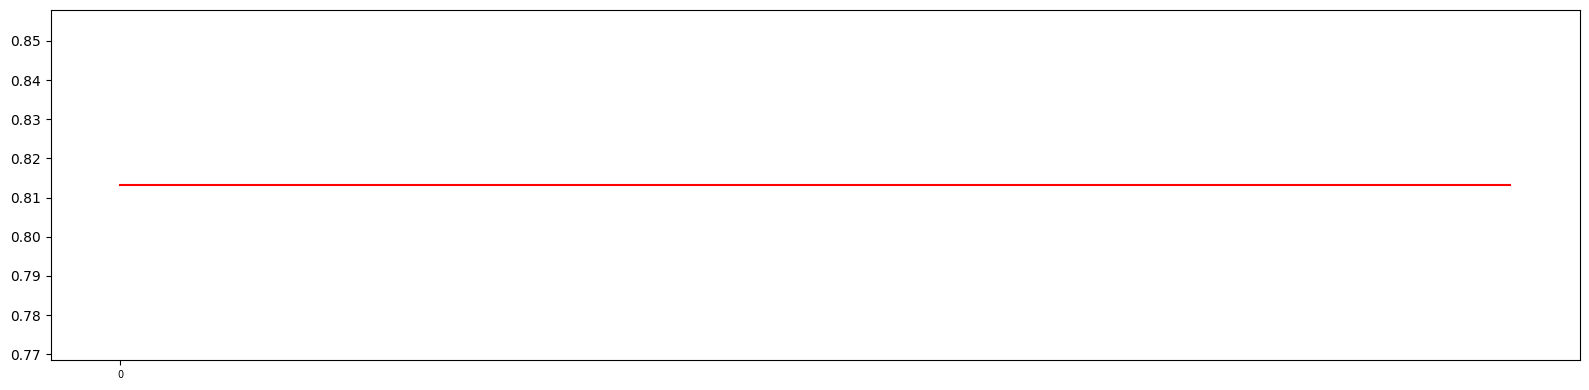

In [45]:
# After fixing global randomness, check random of XGBoost
print ('mean of R2', np.mean(r_squareds_global))
plt.subplots(figsize=(16, 4))
r_squareds_global_mean = np.mean (np.array (r_squareds_global), axis=0)
plt.plot (list(range(len(r_squareds_global_mean))), 
             r_squareds_global_mean);
xticks = list(range(0, len(r_squareds_global_mean), 1));
plt.plot([0, len(r_squareds_global_mean)], 
         [np.mean(r_squareds_global_mean), 
          np.mean(r_squareds_global_mean)], color='red')
plt.xticks(xticks, fontsize=7);
plt.tight_layout()
plt.savefig('randomrun.jpeg', dpi=500)
# what random has the best average for the 5 runs
print ('random of ', np.argmax (r_squareds_global_mean), 
       'with max of: ', np.max (r_squareds_global_mean))

In [43]:
print (np.mean (r_squareds_global))
print (np.std (r_squareds_global))

m = tf.keras.metrics.RootMeanSquaredError()
pred_test = predictions
m.update_state(pred_test, test_labels)
print ('RMSE for test, ', m.result().numpy())

0.8131662350597972
0.056339229412785345
RMSE for test,  12.257462


In [46]:
r_squareds_global

[[0.8713456140025564],
 [0.8443089484221926],
 [0.7078524924592298],
 [0.8089763246065884],
 [0.833347795808419]]

In [47]:
feature_list = ['charge_denisty',
                'material_ps',
                'material_res',
                'material_sa',
                'material_sp2',
                #'material_CB',
                #'material_MC',
                #'material_PA',
                #'material_TCB',
                'PulseTime',
                'Pretreat_voltage',
                'Temp',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Final_Current_Percent',
                'Norm_I_Max',
                'Norm_charge_tot',
                'heat_power']

importances = list(xgbr_graphyield.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];

Variable: charge_denisty Importance: ('charge_denisty', 0.3)
Variable: material_ps Importance: ('material_ps', 0.11)
Variable: material_res Importance: ('material_res', 0.02)
Variable: material_sa Importance: ('material_sa', 0.0)
Variable: material_sp2 Importance: ('material_sp2', 0.02)
Variable: PulseTime Importance: ('PulseTime', 0.03)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.02)
Variable: Temp Importance: ('Temp', 0.12)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.02)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.03)
Variable: Final_Current_Percent Importance: ('Final_Current_Percent', 0.07)
Variable: Norm_I_Max Importance: ('Norm_I_Max', 0.07)
Variable: Norm_charge_tot Importance: ('Norm_charge_tot', 0.11)
Variable: heat_power Importance: ('heat_power', 0.08)


In [51]:
# create df_test
pred_test = xgbr_graphyield.predict(test_new_features)
errors_test = (pred_test.reshape(-1, 1) - test_labels)
errors_abs_test = abs(pred_test.reshape(-1, 1) - test_labels)
id_errors = list(range(errors_test.shape[0]))
#plt.plot(id_errors, errors_test, c=id_test)

df_test = df.loc[idx_test]
df_test['id_errors'] = id_errors
df_test['errors'] = errors_test
df_test['abs_errors'] = errors_abs_test
df_test['Graphene_Yield_per'] = df_test['Graphene_Yield']
df_test['y_pred'] = pred_test
df_test['y_true'] = test_labels

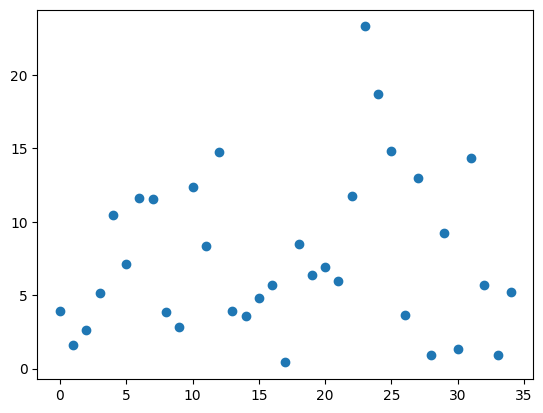

In [15]:
plt.scatter(df_test['id_errors'], df_test['abs_errors'])

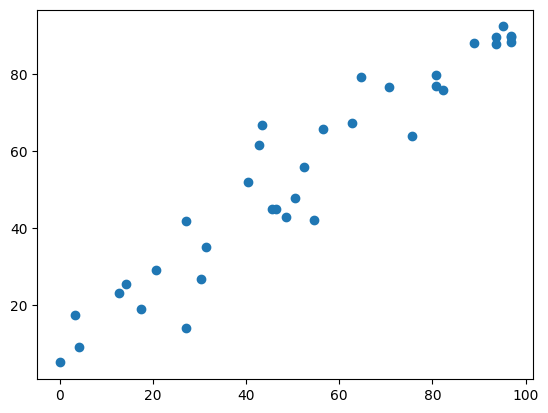

In [16]:
plt.scatter(df_test['y_true'], df_test['y_pred'])

In [17]:
print (df_test['y_true'].loc[df_test['Sample']==90])
print (df_test['y_pred'].loc[df_test['Sample']==90])

Series([], Name: y_true, dtype: float64)
Series([], Name: y_pred, dtype: float32)


In [18]:
r2_score (df_test['y_true'], df_test['y_pred'])

0.9047138922904048

In [19]:
test_labels

array([[80.8080808],
       [17.4603175],
       [50.5050505],
       [ 4.040404 ],
       [12.6984127],
       [96.8253968],
       [75.5102041],
       [14.1414141],
       [31.3131313],
       [95.2380952],
       [54.5454545],
       [96.8253968],
       [64.6464646],
       [93.6507937],
       [30.3030303],
       [62.6262626],
       [93.6507937],
       [45.4545455],
       [20.6349206],
       [82.2916667],
       [96.8253968],
       [70.7070707],
       [40.4040404],
       [43.4343434],
       [42.8571429],
       [26.984127 ],
       [52.3809524],
       [27.0588235],
       [88.8888889],
       [56.5656566],
       [46.4646465],
       [ 3.1746032],
       [48.4848485],
       [80.8080808],
       [ 0.       ]])

In [20]:
df_test['y_pred'].loc[df_test['abs_errors']>20]

98    66.734695
Name: y_pred, dtype: float32

/tmp/ipykernel_84270/3350194207.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:
/tmp/ipykernel_84270/3350194207.py:45: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


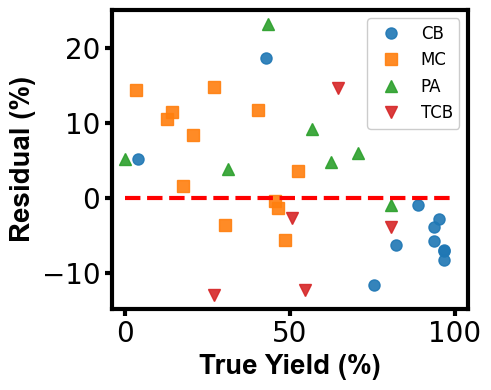

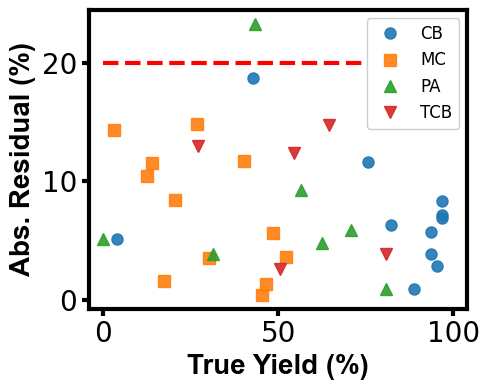

In [21]:
groups = df_test.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend(fontsize=12, framealpha=1)
plt.xticks((0, 50, 100))
x = list(range(0, 100))
y = np.repeat(0, 100)
plt.xlim (-4, 104)
plt.plot(x, y, linestyle='--', color='red', linewidth='3')
ax.set_xlabel('True Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
ax.set_ylabel('Residual (%)', fontsize='20', fontname='Arial', fontweight='bold')
[i.set_linewidth(3) for i in ax.spines.values()]
plt.tight_layout()
plt.savefig('resVSGY_test.jpeg', dpi=500)

pred_test = xgbr_graphyield.predict(test_new_features)
errors_test = abs(pred_test.reshape(-1, 1) - test_labels)
id_errors = list(range(errors_test.shape[0]))
#plt.plot(id_errors, errors_test, c=id_test)

df_test = df.loc[idx_test]
df_test['id_errors'] = id_errors
df_test['errors'] = errors_test
df_test['Graphene_Yield_per'] = df_test['Graphene_Yield']

groups = df_test.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend(fontsize=12, framealpha=1, loc='upper right')
plt.xlim (-4, 104)
x2 = list(range(0, 100))
y2 = np.repeat(20, 100)
plt.plot(x2, y2, linestyle='--', color='red', linewidth='3')
ax.set_xlabel('True Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
ax.set_ylabel('Abs. Residual (%)', fontsize='20', fontname='Arial', fontweight='bold')
[i.set_linewidth(3) for i in ax.spines.values()]
plt.yticks((0, 10, 20))
plt.xticks((0, 50, 100))
plt.tight_layout()
plt.tight_layout()
plt.savefig('abs_resVSGY_test.jpeg', dpi=500)

/tmp/ipykernel_84270/2633315224.py:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


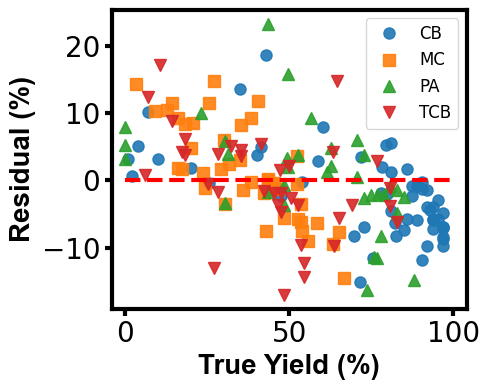

In [22]:
labels = Graphene_Yield
predictions = xgbr_graphyield.predict(new_features)
errors_all = (predictions.reshape(-1, 1) - labels)

df['errors'] = errors_all
df['Graphene_Yield_per'] = df['Graphene_Yield']

groups = df.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5,4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')

counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend(fontsize=12)
[i.set_linewidth(3) for i in ax.spines.values()]
plt.xlim (-4, 104)
x = list(range(0, 100))
y = np.repeat(0, 100)
plt.xticks((0, 50, 100))
plt.plot(x, y, linestyle='--', color='red', linewidth='3')
ax.set_xlabel('True Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
ax.set_ylabel('Residual (%)', fontsize='20', fontname='Arial', fontweight='bold')
plt.tight_layout()
plt.tight_layout()
plt.savefig('resVSGY.jpeg', dpi=500)

/tmp/ipykernel_84270/4248746353.py:17: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


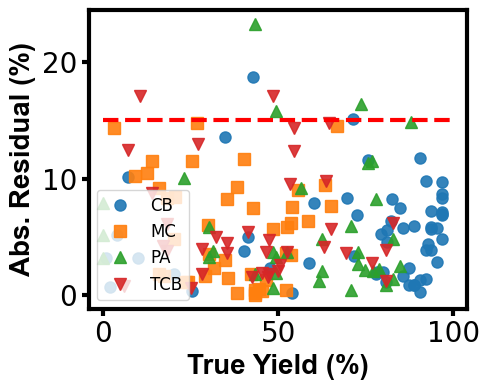

In [23]:
labels = Graphene_Yield
predictions = xgbr_graphyield.predict(new_features)
errors_all = abs(predictions.reshape(-1, 1) - labels)

df['errors'] = errors_all
df['Graphene_Yield_per'] = df['Graphene_Yield']

groups = df.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5,4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend(fontsize=12)
[i.set_linewidth(3) for i in ax.spines.values()]
ax.set_xlabel('True Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
ax.set_ylabel('Abs. Residual (%)', fontsize='20', fontname='Arial', fontweight='bold')
plt.xlim (-4, 104)

x2 = list(range(0, 100))
y2 = np.repeat(15, 100)
plt.plot(x2, y2, linestyle='--', color='red', linewidth='3')

plt.tight_layout()
plt.tight_layout()
plt.savefig('abs_resVSGY.jpeg', dpi=500)

/tmp/ipykernel_84270/2633125660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred'] = pred_test
/tmp/ipykernel_84270/2633125660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_true'] = test_labels
/tmp/ipykernel_84270/2633125660.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in gro

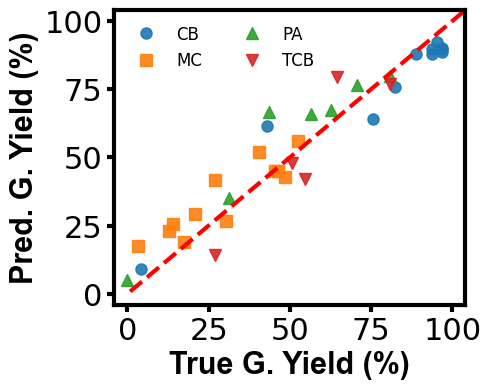

In [24]:
df_test = df.iloc[idx_test]
df_test['y_pred'] = pred_test
df_test['y_true'] = test_labels
groups = df_test.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='22')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.y_true, group.y_pred, marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Pred. 2D/G
#plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
[i.set_linewidth(3) for i in ax.spines.values()]
ax.set_ylabel('Pred. G. Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
ax.set_xlabel('True G. Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
[i.set_linewidth(3) for i in ax.spines.values()]
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2, y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper left')
plt.xlim (-4, 104)
plt.ylim (-4, 104)
plt.xticks((0, 25, 50, 75, 100))
plt.yticks((0, 25, 50, 75, 100))

# Save
plt.tight_layout()
plt.savefig('XGBPerformance_matg.jpeg', dpi=500)
